# Adagrad
SGD,Momentum都是固定学习率的优化方法.Adagrad采用自适应学习率来优化更新.

**SGD**的更新函数:
$$
\theta_{i+1} = \theta_i - \eta \nabla L(\theta)
$$
**Adagrad**的更新函数:
$$
\theta_{i+1} = \theta_i- \frac{\eta}{\sqrt{s + \epsilon}}\nabla L(\theta)
$$
- 其中,$s$是模型**从训练开始的梯度平方的累加.** 

- $\epsilon$ 是为了数值稳定性而加上的，因为有可能 s 的值为 0，那么 0 出现在分母就会出现无穷大的情况，通常 $\epsilon$ 取 $10^{-10}$.


1. 优点: *如此一来,就达到了一中效果: 某个参数梯度大,但是学习率小;另一个参数梯度小,但是学习率大.**
2. 缺点: 因为是梯度平方的累加,导致分母后期很大,整体的学习率变小,收敛速度变慢.

## 一. 手动实现Adagrad

In [8]:
def sgd_adagrad(parameters,sqrs,lr):
    eps=1e-10 #防止分母为零
    for param, sqr in zip(parameters,sqrs):
        sqr[:]=sqr+param.grad.data**2 #累加梯度的平方
        div=lr/torch.sqrt(sqr+eps)*param.grad.data
        param.data=param.data-div

In [5]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch import nn
import time
import matplotlib.pyplot as plt

In [12]:
def data_tf(x):
    x=np.array(x,dtype='float32')
    x=(x-0.5)/0.5
    x=x.reshape((-1,))
    x=torch.Tensor(x)
    return x
train_set=MNIST('../data',train=True,transform=data_tf,download=True)
test_set=MNIST('../data',train=False,transform=data_tf,download=True)

criterion=nn.CrossEntropyLoss()

train_data=DataLoader(train_set,batch_size=64, shuffle=True)
net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))

#初始化梯度平方项
sqrs=[]
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
#开始训练
losses=[]
idx=0
start=time.time()
for e in range(5):
    train_loss=0
    for im,label in train_data:
        out=net(Variable(im))
        loss=criterion(out,Variable(label))
        net.zero_grad()
        loss.backward()
        sgd_adagrad(net.parameters(),sqrs,1e-2)
        train_loss+=loss.item()
        if idx%30==0:
            losses.append(loss.item())
        idx+=1
    print('epoch:{},loss:{:.5f}'.format(e,train_loss/len(train_data)))
print('Used {:.5f}s'.format(time.time()-start))

epoch:0,loss:2.13282
epoch:1,loss:0.25222
epoch:2,loss:0.18310
epoch:3,loss:0.14787
epoch:4,loss:0.12313
Used 30.83085s


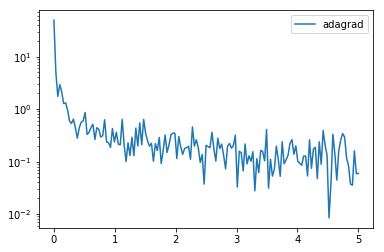

In [13]:
x_axis=np.linspace(0,5,len(losses),endpoint=True)
plt.semilogy(x_axis,losses,label='adagrad')
plt.legend(loc='best')

## 二.使用自带Adagrad: `torch.optim.Adagrad()`

In [15]:
train_data=DataLoader(train_set,batch_size=64,shuffle=True)
net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adagrad(net.parameters(),lr=0.01)

start=time.time()
for e in range(5):
    train_loss=0
    for im,label in train_data:
        out=net(Variable(im))
        loss=criterion(out,Variable(label))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
    print('epoch:{},loss:{:.5f}'.format(e,train_loss/len(train_data)))
print('Used {:.5f}s'.format(time.time()-start))

epoch:0,loss:2.72052
epoch:1,loss:0.27309
epoch:2,loss:0.19462
epoch:3,loss:0.15696
epoch:4,loss:0.13266
Used 28.71618s
